In [94]:
# https://github.com/derekgreene/topic-model-tutorial/blob/master/3%20-%20Parameter%20Selection%20for%20NMF.ipynb
from pathlib import Path
import re, joblib
from itertools import combinations
import numpy as np
from sklearn import decomposition
import gensim
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
# settings for our plots later
plt.style.use("ggplot")
matplotlib.rcParams.update({"font.size": 14})

In [95]:
(A,terms,snippets) = joblib.load("articles-tfidf.pkl")
print("Loaded %d X %d document-term matrix" % (A.shape[0], A.shape[1]))

Loaded 28 X 78 document-term matrix


In [96]:
kmin, kmax = 4, 25

In [97]:
topic_models = []
# try each value of k
for k in range(kmin,kmax+1):
    print("Applying NMF for k=%d ..." % k )
    # run NMF
    model = decomposition.NMF( init="nndsvd", n_components=k ) 
    W = model.fit_transform( A )
    H = model.components_    
    # store for later
    topic_models.append( (k,W,H) )

Applying NMF for k=4 ...
Applying NMF for k=5 ...
Applying NMF for k=6 ...
Applying NMF for k=7 ...
Applying NMF for k=8 ...
Applying NMF for k=9 ...
Applying NMF for k=10 ...
Applying NMF for k=11 ...
Applying NMF for k=12 ...
Applying NMF for k=13 ...
Applying NMF for k=14 ...
Applying NMF for k=15 ...
Applying NMF for k=16 ...
Applying NMF for k=17 ...
Applying NMF for k=18 ...
Applying NMF for k=19 ...
Applying NMF for k=20 ...
Applying NMF for k=21 ...
Applying NMF for k=22 ...
Applying NMF for k=23 ...
Applying NMF for k=24 ...
Applying NMF for k=25 ...


C:\Users\vitto\anaconda3\lib\site-packages\sklearn\decomposition\_nmf.py:1770: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


In [98]:
in_path = Path("data") / "articles.txt"
raw_documents = []
with open(in_path, "r", encoding="utf8") as fin:
    # each line is a document
    for line in fin.readlines():
        raw_documents.append(line.strip().lower())
print("Read %d raw text documents" % len(raw_documents))

Read 28 raw text documents


In [99]:
custom_stop_words = []
with open("stopwords.txt", "r", encoding="utf8") as fin:
    for line in fin.readlines():
        custom_stop_words.append(line.strip().lower())
# note that we need to make it hashable
print("Stopword list has %d entries" % len(custom_stop_words))

Stopword list has 1298 entries


In [100]:
class TokenGenerator:
    def __init__(self, documents, stopwords):
        self.documents = documents
        self.stopwords = stopwords
        self.tokenizer = re.compile( r"(?u)\b\w\w+\b" )

    def __iter__(self):
        print("Building Word2Vec model ...")
        for doc in self.documents:
            tokens = []
            for tok in self.tokenizer.findall( doc ):
                if tok in self.stopwords:
                    tokens.append( "<stopword>" )
                elif len(tok) >= 2:
                    tokens.append( tok )
            yield tokens

In [101]:
docgen = TokenGenerator(raw_documents, custom_stop_words)
# the model has 500 dimensions, the minimum document-term frequency is 20
w2v_model = gensim.models.Word2Vec(docgen, vector_size=500, min_count=5, sg=1)

Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...
Building Word2Vec model ...


In [102]:
print("Model has %d terms" % len(w2v_model.wv.key_to_index))

Model has 152 terms


In [103]:
w2v_model.save("w2v-model.bin")

In [104]:
# To re-load this model, run
#w2v_model = gensim.models.Word2Vec.load("w2v-model.bin")

In [105]:
def calculate_coherence(w2v_model, term_rankings):
    overall_coherence = 0.0
    for topic_index in range(len(term_rankings)):
        # check each pair of terms
        pair_scores = []
        for pair in combinations( term_rankings[topic_index], 2 ):
            pair_scores.append( w2v_model.wv.similarity(pair[0], pair[1]) )
        # get the mean for all pairs in this topic
        topic_score = sum(pair_scores) / len(pair_scores)
        overall_coherence += topic_score
    # get the mean score across all topics
    return overall_coherence / len(term_rankings)

In [106]:
def get_descriptor( all_terms, H, topic_index, top ):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( H[topic_index,:] )[::-1]
    # now get the terms corresponding to the top-ranked indices
    top_terms = []
    for term_index in top_indices[0:top]:
        top_terms.append( all_terms[term_index] )
    return top_terms

In [107]:
k_values = []
coherences = []
for (k,W,H) in topic_models:
    # Get all of the topic descriptors - the term_rankings, based on top 10 terms
    term_rankings = []
    for topic_index in range(k):
        term_rankings.append( get_descriptor( terms, H, topic_index, 10 ) )
    # Now calculate the coherence based on our Word2vec model
    k_values.append( k )
    coherences.append( calculate_coherence( w2v_model, term_rankings ) )
    print("K=%02d: Coherence=%.4f" % ( k, coherences[-1] ) )

K=04: Coherence=0.9993
K=05: Coherence=0.9993
K=06: Coherence=0.9993
K=07: Coherence=0.9993
K=08: Coherence=0.9993
K=09: Coherence=0.9993
K=10: Coherence=0.9993
K=11: Coherence=0.9993
K=12: Coherence=0.9993
K=13: Coherence=0.9993
K=14: Coherence=0.9993
K=15: Coherence=0.9993
K=16: Coherence=0.9993
K=17: Coherence=0.9993
K=18: Coherence=0.9993
K=19: Coherence=0.9993
K=20: Coherence=0.9993
K=21: Coherence=0.9993
K=22: Coherence=0.9993
K=23: Coherence=0.9993
K=24: Coherence=0.9993
K=25: Coherence=0.9993


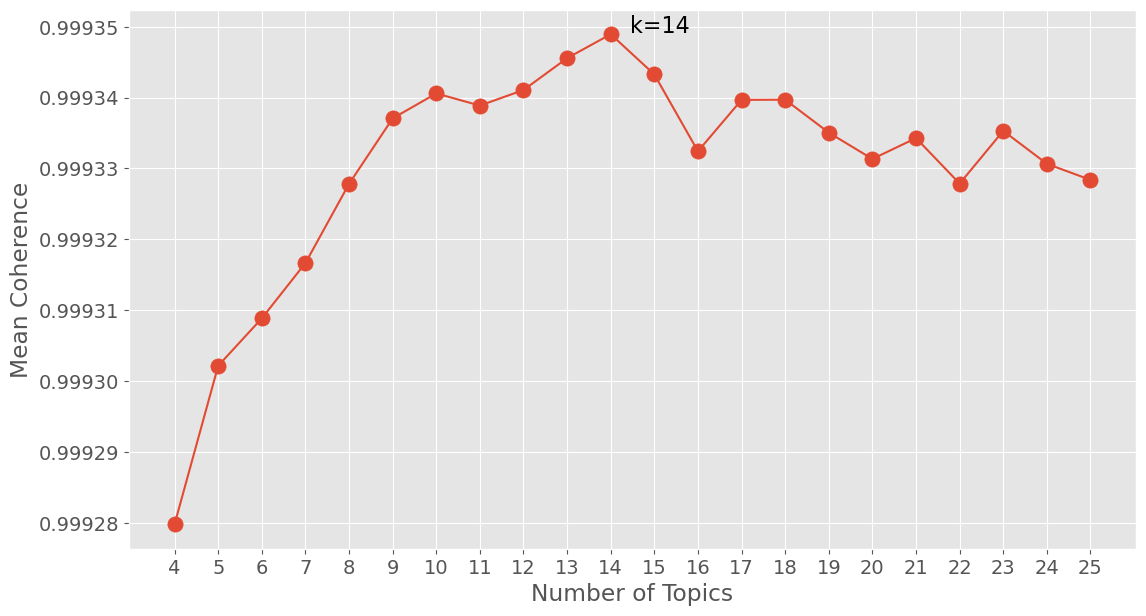

In [108]:
fig = plt.figure(figsize=(13,7))
# create the line plot
ax = plt.plot( k_values, coherences )
plt.xticks(k_values)
plt.xlabel("Number of Topics")
plt.ylabel("Mean Coherence")
# add the points
plt.scatter(k_values, coherences, s=120)
# find and annotate the maximum point on the plot
ymax = max(coherences)
xpos = coherences.index(ymax)
best_k = k_values[xpos]
plt.annotate("k=%d" % best_k, xy=(best_k, ymax), xytext=(best_k, ymax), textcoords="offset points", fontsize=16)
# show the plot
plt.show()

In [109]:
k = best_k
# get the model that we generated earlier.
W = topic_models[k-kmin][1]
H = topic_models[k-kmin][2]

In [110]:
import os
if os.path.exists('Results/07_Topics.txt'):
    os.remove('Results/07_Topics.txt')

for topic_index in range(k):
    descriptor = get_descriptor(terms, H, topic_index, 5)
    str_descriptor = ", ".join(descriptor)
    #print("Topic %02d: %s" % (topic_index+1, str_descriptor) )
    print(f'Topic %02d: %s' % (topic_index+1, str_descriptor), file=open('Results/Topics.txt', 'a')) # a

In [111]:
from statistics import mean
import statistics

def plot_top_term_weights(terms, H, topic_index, top):
    # get the top terms and their weights
    top_indices = np.argsort(H[topic_index,:])[::-1]
    top_terms = []
    top_weights = []
    for term_index in top_indices[0:top]:
        top_terms.append(terms[term_index])
        top_weights.append(H[topic_index,term_index])
    # note we reverse the ordering for the plot
    top_terms.reverse()
    top_weights.reverse()
    print('Topic_' + str(topic_index) + ', Top-Term Weight: ' + str(top_weights[14]))
    # create the plot
    """
    fig = plt.figure(figsize=(13,8))
    # add the horizontal bar chart
    ypos = np.arange(top)
    ax = plt.barh(ypos, top_weights, align="center", color="green",tick_label=top_terms)
    plt.xlabel("Term Weight",fontsize=14)
    plt.tight_layout()
    # plt.show()
    plt.savefig('Results/Topic_' + str(topic_index) + '_plot_topic_bars.png', dpi=300, bbox_inches='tight', format="PNG")
    """

In [112]:
indx = 0
while indx < k:
    plot_top_term_weights(terms, H, indx, 15) # Topic (X-1)
    indx = indx + 1

#plot_top_term_weights(terms, H, 5, 15) # Topic (X-1)

Topic_0, Top-Term Weight: 1.4545183130914154
Topic_1, Top-Term Weight: 1.0899665764916675
Topic_2, Top-Term Weight: 0.9823569239788863
Topic_3, Top-Term Weight: 1.1917906968377876
Topic_4, Top-Term Weight: 0.8278977640360826
Topic_5, Top-Term Weight: 1.2232584836817157
Topic_6, Top-Term Weight: 0.7868967944437185
Topic_7, Top-Term Weight: 0.7974775075087808
Topic_8, Top-Term Weight: 0.8813351394948152
Topic_9, Top-Term Weight: 0.7819022661831919
Topic_10, Top-Term Weight: 0.8313284002479635
Topic_11, Top-Term Weight: 0.6266772358040443
Topic_12, Top-Term Weight: 0.6826565051124351
Topic_13, Top-Term Weight: 0.5885376006867263


In [113]:
def get_top_snippets(all_snippets, W, topic_index, top):
    # reverse sort the values to sort the indices
    top_indices = np.argsort( W[:,topic_index] )[::-1]
    print(top_indices)
    # now get the snippets corresponding to the top-ranked indices
    top_snippets = []
    for doc_index in top_indices[0:top]:
        top_snippets.append(all_snippets[doc_index])
    return top_snippets

In [118]:
import pandas as pd

indx = 0
while indx < k:
    topic_snippets = get_top_snippets(snippets, W, indx, 25)
    data = []
    for i, snippet in enumerate(topic_snippets):
        # print("%02d. %s" % ((i+1), snippet ))
        titleSnip = str(snippet)
        title = titleSnip.split(';') # [0];
        print(title[0])
        data.append({'Title': title[0]})
    df = pd.DataFrame(data, columns=['Title'])
    # Saving first group of data to a single csv file
    df.to_csv('Results/Topic_' + str(indx+1) + '_paper_most_related.csv')
    indx = indx + 1

[ 1 19 24 18  3 17 14  2  7  8  0  9 10  4  5  6 27 11 12 26 15 16 20 21
 22 23 25 13]
The challenges of emerging software eco-systems
PSY-TaLiRo: A Python Toolbox for Search-Based Test Generation for Cyber-Physical Systems
Contemporary Challenges when Developing Cyber-Physical Systems of Systems - A Case Study
Assurance and certification of cyber–physical systems: The AMASS open source ecosystem
Quo vadis cyber-physical systems: Research areas of cyber-physical ecosystems
Smart systems of innovation for smart places: Challenges in deploying digital platforms for co-creat
NLES: A novel lifetime extension scheme for safety-critical cyber-physical systems using SDN and NFV
Models@run.time for creating in-cloud dynamic cyber-physical ecosystems
Software interoperability analysis in practice - A survey
Development of an embedded platform for secure CPS services
Modular verification of dynamically adaptive systems
Elastic systems: Towards cyber-physical ecosystems of people, processes, and 